# Response to Stochastic Process input

we feed the neuron with spikes draw from an inhomogeneous Poisson process whose time-varying rate is set by a temporally correlated stochastic process (Ornstein-Uhlenbeck process)

In [2]:
import numpy as np

import sys
from parallel import Parallel

sys.path.append('../..')
import plot_tools as pt
import matplotlib.pylab as plt
sys.path.append('../../analyz')
from analyz.signal_library.stochastic_processes import OrnsteinUhlenbeck_Process
from analyz.processing.signanalysis import autocorrel, crosscorrel

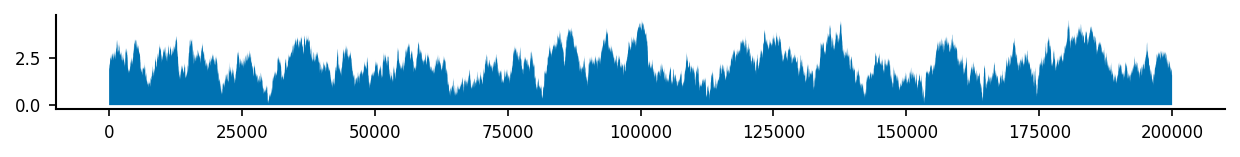

In [3]:
def OrnsteinUhlenbeck_Process(mu, sigma, tau, 
                              dt=0.1, tstop=100):
    """ taken from github.com/yzerlaut/analyz """
    diffcoef = 2*sigma**2/tau
    y0, n_steps= mu, int(tstop/dt)
    A = np.sqrt(diffcoef*tau/2.*(1-np.exp(-2*dt/tau)))
    noise, y = np.random.randn(n_steps), np.zeros(n_steps)
    y[0] = y0
    for i in range(n_steps-1):
        y[i+1] = y0 + (y[i]-y0)*np.exp(-dt/tau)+A*noise[i]
    return y
np.random.seed(1)
X = np.clip(OrnsteinUhlenbeck_Process(2, .75, 50, dt=0.025, tstop=5e3), 0, np.inf)
fig, ax = pt.figure(figsize=(3,1))
ax.fill_between(range(len(X)), 0*X, X)

In [4]:
from scipy.ndimage import gaussian_filter1d

rate_smoothing = 10. # ms

RESULTS = {'Martinotti_example_index':0,
           'Basket_example_index':0}

#cellType, color = 'Martinotti', 'tab:orange'
for cellType, color in zip(['Martinotti', 'Basket'], ['tab:orange', 'tab:red']):

    sim = Parallel(\
            filename='../../data/detailed_model/tvRateStim_demo_%s.zip' % cellType)
    sim.load()

    sim.fetch_quantity_on_grid('spikes', dtype=list)

    seeds = np.unique(sim.spikeSeed)

    dt = sim.fetch_quantity_on_grid('dt', return_last=True)
    tstop = sim.fetch_quantity_on_grid('tstop', return_last=True)

    spikes_matrix= np.zeros((len(seeds), int(tstop/dt)+1))
    RESULTS['%s_rate' % cellType] = []
    for i, spikes in enumerate(sim.spikes):
        spikes_matrix[i,(spikes/dt).astype('int')] = True
    RESULTS['rate_%s' % cellType] = 1e3*gaussian_filter1d(np.mean(spikes_matrix, axis=0)/dt,
                                                           int(rate_smoothing/dt))
    

    RESULTS['stimFreq_%s' % cellType] = sim.fetch_quantity_on_grid('stimFreq', return_last=True)
    RESULTS['bgFreqInhFactor_%s' % cellType] = sim.fetch_quantity_on_grid('bgFreqInhFactor', return_last=True)

    sim.fetch_quantity_on_grid('OU', return_last=True, dtype=np.ndarray)
    RESULTS['Input_%s' % cellType] = sim.OU[RESULTS['%s_example_index' % cellType]]
    sim.fetch_quantity_on_grid('Vm_soma', return_last=True, dtype=np.ndarray)
    RESULTS['Vm_%s' % cellType] = sim.Vm_soma[RESULTS['%s_example_index' % cellType]]
    sim.fetch_quantity_on_grid('presynaptic_exc_events', dtype=list)
    RESULTS['pre_exc_%s' % cellType] = sim.presynaptic_exc_events[RESULTS['%s_example_index' % cellType]]
    sim.fetch_quantity_on_grid('presynaptic_inh_events', dtype=list)
    RESULTS['pre_inh_%s' % cellType] = sim.presynaptic_inh_events[RESULTS['%s_example_index' % cellType]]
    RESULTS['t'] = np.arange(len(RESULTS['rate_%s' % cellType]))*dt
    RESULTS['dt'] = dt
    print(cellType, '%.2f Hz' % np.mean(RESULTS['rate_%s' % cellType][RESULTS['t']>2e3]))

Martinotti 12.62 Hz
Basket 9.75 Hz


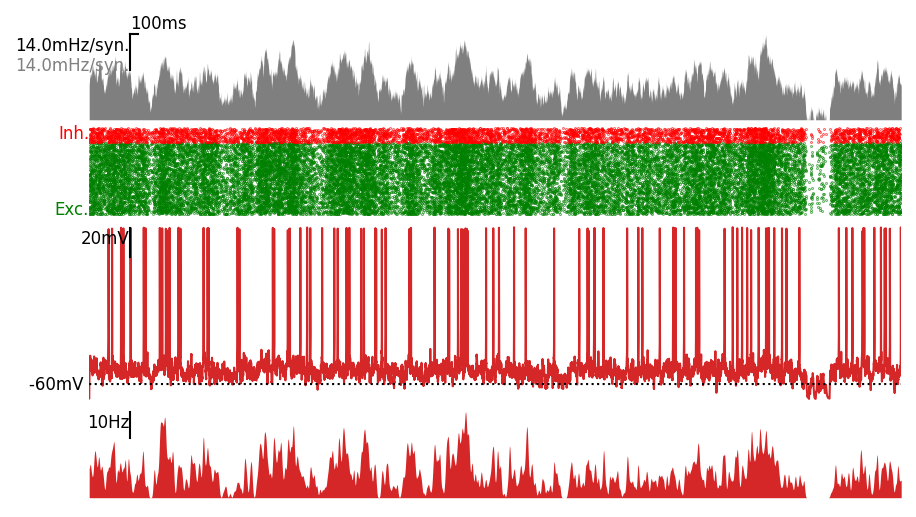

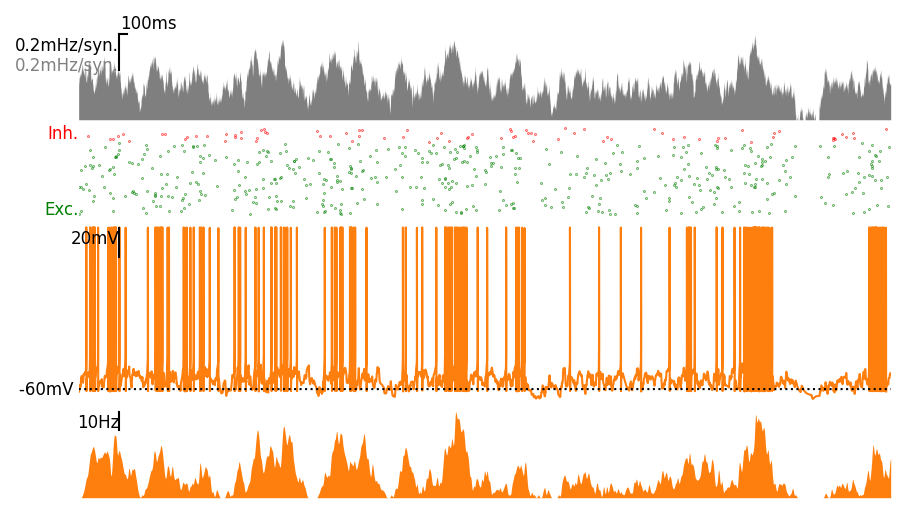

In [5]:
zoom = [0, 10e3]

for cellType, color in zip(['Basket', 'Martinotti'], ['tab:red', 'tab:orange']):

    """
    results = np.load('../../data/detailed_model/demo-tvRate-%s.npy' % cellType, allow_pickle=True).item()
    print(cellType, 1e3*len(results['spikes'])/results['tstop'])
    RESULTS['t'] = np.arange(len(results['Vm_soma']))*results['dt']
    RESULTS['Vm_%s' % cellType] = results['Vm_soma']
    RESULTS['Input_%s' % cellType] = results['OU']
    RESULTS['pre_exc_%s' % cellType] = results['presynaptic_exc_events']
    RESULTS['pre_inh_%s' % cellType] = results['presynaptic_inh_events']
    RESULTS['rate_%s' % cellType] = None
    """
    
    fig, AX = pt.figure(axes_extents=[[(1,1)],[(1,1)],[(1,2)],[(1,1)]],
                        figsize=(2.5,1), left=0, bottom=0., hspace=0.)

    # input
    AX[0].fill_between(RESULTS['t'][:-1], 0*RESULTS['t'][:-1], RESULTS['Input_%s' % cellType],
                       color='tab:grey', lw=0)
    
    # Vm
    AX[2].plot(RESULTS['t'], RESULTS['Vm_%s' % cellType], color=color)
    AX[2].plot(RESULTS['t'], -60+0*RESULTS['t'], 'k:')

    # rate
    if RESULTS['rate_%s' % cellType] is not None:
        AX[3].fill_between(RESULTS['t'], 0*RESULTS['t'], RESULTS['rate_%s' % cellType],
                           color=color, lw=0)
    
    # events
    if 'pre_inh_%s'%cellType in RESULTS:
        # 1/4 for display
        for i, events in enumerate(RESULTS['pre_exc_%s' % cellType][:200]):
            AX[1].plot(events, i*np.ones(len(events)), '.', color='g', ms=.5)
        for i, events in enumerate(RESULTS['pre_inh_%s' % cellType][:40]):
            AX[1].plot(events, 200+i*np.ones(len(events)), '.', 
                       color='r', ms=.5)

    pt.set_common_xlims(AX, lims=zoom)
    
    pt.draw_bar_scales(AX[0], Xbar=100, Xbar_label='100ms', Ybar=2,
                       Ybar_label='%.1fmHz/syn.' % (2*1e3*RESULTS['stimFreq_%s' % cellType]),
                       Ybar_label2='%.1fmHz/syn.' % (2*1e3*RESULTS['stimFreq_%s' % cellType]*RESULTS['bgFreqInhFactor_%s' % cellType]))
    pt.annotate(AX[2], '-60mV ', (zoom[0],-60), xycoords='data', ha='right', va='center')
    pt.draw_bar_scales(AX[2], Xbar=1e-12, Ybar=20,Ybar_label='20mV')
    pt.annotate(AX[1], 'Inh.', (0,1), ha='right', va='top', color='r')
    pt.annotate(AX[1], 'Exc.', (0,0), ha='right', va='bottom', color='g')
    for ax in AX:
        ax.axis('off')
    pt.draw_bar_scales(AX[3], Xbar=1e-12, Ybar=10,Ybar_label='10Hz')

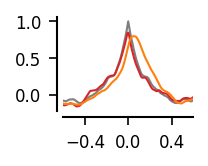

In [7]:
fig, ax = pt.figure()
subsampling = 100
CCs = {}

for cellType, color in zip(['Basket', 'Martinotti'], ['tab:red', 'tab:orange']):

    cond = RESULTS['t']>1
    # input
    if cellType=='Basket':
        CCF, time_shift = crosscorrel(RESULTS['Input_%s' % cellType][cond[1:]][::subsampling], 
                              RESULTS['Input_%s' % cellType][cond[1:]][::subsampling], 
                              1e3, subsampling*RESULTS['dt'])
        ax.plot(time_shift/1e3, CCF, color='tab:grey')
        CCs['Input_CC'] = CCF
    
    cond = RESULTS['t']>1e3
    CCF, time_shift = crosscorrel(RESULTS['Input_%s' % cellType][cond[1:]][::subsampling], 
                          RESULTS['rate_%s' % cellType][1:][cond[1:]][::subsampling], 
                          1e3, subsampling*RESULTS['dt'])
    
    ax.plot(time_shift/1e3, CCF, color=color)
    CCs['%s_CC' % cellType] = CCF
    
    CCs['time_shift'] = time_shift

pt.set_plot(ax, xlim=[-0.6,0.6])

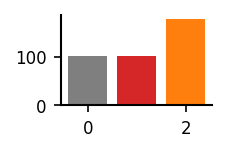

In [8]:
# Exponential fit to quantify the decay

from scipy.optimize import minimize

def fit_exponential_decay(shift, array,
                          min_time=10,
                          max_time=1000):
    def func(X):
        return np.sum(np.abs(np.exp(-shift/X[0])-array))
    res = minimize(func, [min_time],
                   bounds=[[min_time, max_time]], method='L-BFGS-B')
    return res.x[0]

fig2, ax = plt.subplots(1, figsize=(1.3, 0.8))

for k, cellType, color in zip(range(2),
                              ['Basket', 'Martinotti'],
                              ['tab:red', 'tab:orange']):

    i0 = int(len(CCs['time_shift'])/2)
    
    tau = fit_exponential_decay(CCs['time_shift'][i0:], CCs['%s_CC' % cellType][i0:]/CCs['%s_CC' % cellType][i0])
    ax.bar([1+k], [tau], color=color)

    if cellType=='Basket':
        tau = fit_exponential_decay(CCs['time_shift'][i0:], CCs['Input_CC'][i0:]/CCs['Input_CC'][i0])
        ax.bar([0], [tau], color='tab:grey')
    

    #ax11.bar([k], [CCF[int(len(time_shift)/2)]], color=pos_color)
    
    #plt.plot(ts, np.exp(-ts/tau), color=color)

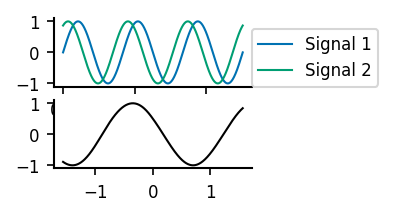

In [51]:
t = np.linspace(0, np.pi*2, int(1000))
Signal1 = np.sin(3*t)
Signal2 = np.cos(3*t-np.pi/6)
_, ax = plt.subplots(2)
ax[0].plot(t, Signal1, label='Signal 1')
ax[0].plot(t, Signal2, label='Signal 2')
ax[0].legend(loc=(1,0))
cr, t_shift = crosscorrel(Signal1, Signal2, np.pi/2., t[1]-t[0])
ax[1].plot(t_shift, cr, 'k-')

In [49]:
sim = Parallel(\
        filename='../../data/detailed_model/tvRateStim_demo_%s.zip' % cellType)
sim.load()

sim.fetch_quantity_on_grid('spikes', dtype=list)


In [18]:
from scipy.ndimage import gaussian_filter1d

rate_smoothing = 10. # ms
RESULTS = {}

#cellType, color = 'Martinotti', 'tab:orange'
for cellType, color in zip(['Martinotti', 'Basket'], ['tab:orange', 'tab:red']):

    sim = Parallel(\
            filename='../../data/detailed_model/tvRateStim_sim_%s.zip' % cellType)
    sim.load()

    sim.fetch_quantity_on_grid('spikes', dtype=list)

    seeds = np.unique(sim.stochProcSeed)
    nRepeats = int(np.product(sim.spikes.shape)/len(seeds))

    dt = sim.fetch_quantity_on_grid('dt', return_last=True)
    tstop = sim.fetch_quantity_on_grid('tstop', return_last=True)

    spikes_matrix= np.zeros((len(seeds), nRepeats, int(tstop/dt)+1))
    RESULTS['%s_rates' % cellType] = []
    for s, seed in enumerate(seeds):
        for i, spikes in enumerate(sim.spikes[sim.stochProcSeed==seed]):
            spikes_matrix[s,i,(spikes/dt).astype('int')] = True
        rate = 1e3*gaussian_filter1d(np.mean(spikes_matrix[s,:,:], axis=0)/dt,
                                     int(rate_smoothing/dt))
        RESULTS['%s_rates' % cellType].append(rate)
        print(cellType, 'seed', s, np.mean(rate))

    sim.fetch_quantity_on_grid('OU', return_last=True, dtype=np.ndarray)
    RESULTS['StochProc'] = []
    for s, seed in enumerate(seeds):
        RESULTS['StochProc'].append(sim.OU[sim.stochProcSeed==seed][0])
    RESULTS['t'] = np.arange(len(rate))*dt

Martinotti seed 0 12.577484278144652
Martinotti seed 1 12.362484546894313
Basket seed 0 8.864988918763855
Basket seed 1 8.579989275013407


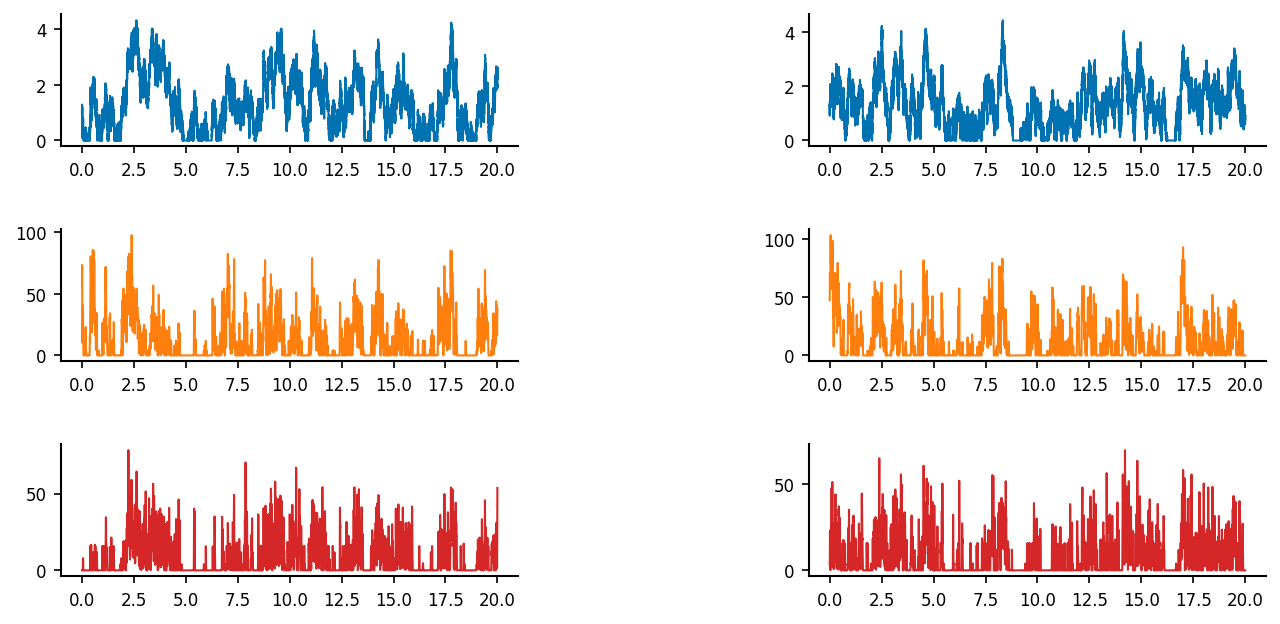

In [14]:
fig, AX = pt.figure(axes=(len(seeds),3), figsize=(2,1.4))

for s, seed in enumerate(seeds):
    AX[0][s].plot(RESULTS['t'][:-1]/1e3, RESULTS['StochProc'][s])
    for c, cellType, color in zip(range(2), ['Martinotti', 'Basket'], ['tab:orange', 'tab:red']):
        AX[1+c][s].plot(RESULTS['t']/1e3, RESULTS['%s_rates' % cellType][s], color)

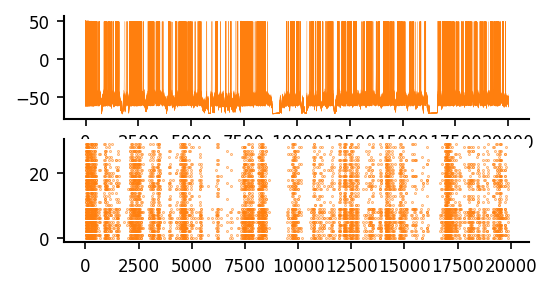

In [30]:
iSeed = 0

sim.fetch_quantity_on_grid('Vm_soma', dtype=list)

Spikes = []
fig, AX = plt.subplots(2, figsize=(4,2))

seed = 1

flat_seeds = sim.stochProcSeed.reshape(np.product(sim.stochProcSeed.shape))
cond = flat_seeds==seed

for i, vm in enumerate(sim.Vm_soma.reshape(np.product(sim.Vm_soma.shape))[cond]):
    t = np.arange(len(vm))*dt
    spikes = find_spikes(t, vm)
    AX[0].plot(t, vm, '-', lw=0.1, color=color)
    AX[1].plot(spikes, i+0*spikes, '.', color=color, ms=0.5)
    Spikes.append(spikes)

In [11]:
spikes_matrix= np.zeros((len(Spikes), int(tstop/dt)+1))
for i, spikes in enumerate(Spikes):
    spikes_matrix[i,(spikes/dt).astype('int')] = True

NameError: name 'tstop' is not defined

7.0741578239693865

In [56]:
tstop = sim.fetch_quantity_on_grid('tstop', return_last=True)


In [57]:
OU = sim.fetch_quantity_on_grid('OU', return_last=True, dtype=np.ndarray)

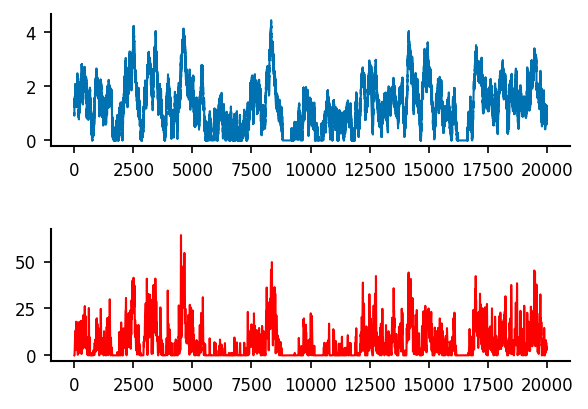

## Compute cross-correlation functions

In [36]:
subsampling = 20
for c, cellType, color in zip(range(2), ['Martinotti', 'Basket'], ['tab:orange', 'tab:red']):
    RESULTS['%s_CCs' % cellType] = []
    for s in range(len(seeds)):
        CCF, ts = crosscorrel(RESULTS['%s_rates' % cellType][s][1:][::subsampling],
                              RESULTS['StochProc'][s][::subsampling], 
                              1e3, subsampling*dt)
        RESULTS['%s_CCs' % cellType].append(CCF)
    
RESULTS['CC_StochProc'] = []
for sc in RESULTS['StochProc']:
    CCF, ts = crosscorrel(sc[::subsampling], sc[::subsampling],
                          1e3, subsampling*dt)
    RESULTS['CC_StochProc'].append(CCF)

### plot

(None, <AxesSubplot:>)

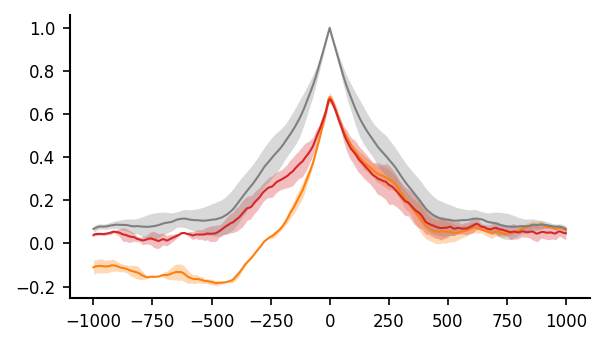

In [37]:
fig, ax = pt.figure(figsize=(2,3))

for c, cellType, color in zip(range(2), ['Martinotti', 'Basket'], ['tab:orange', 'tab:red']):
    pt.plot(ts, np.mean(RESULTS['%s_CCs' % cellType], axis=0),
             sy=stats.sem(RESULTS['%s_CCs' % cellType], axis=0),
             color=color, ax=ax)  
pt.plot(ts, np.mean(RESULTS['CC_StochProc'], axis=0),
        sy=stats.sem(RESULTS['CC_StochProc'], axis=0),
        color='tab:grey', ax=ax)
    
#pt.set_plot(ax, xlim=[-1000,1000])

In [30]:
for sc in RESULTS['StochProc']:
    CCF, ts = crosscorrel(sc, sc,
                          1e3, subsampling*RESULTS['dt'])
    RESULTS['CC_StochProc'].append(CCF)
pt.plot(ts, np.mean(RESULTS['CC_StochProc'], axis=0),
        sy=stats.sem(RESULTS['CC_StochProc'], axis=0),
        color='tab:grey', ax=ax)


KeyError: 'dt'

In [28]:
RESULTS['CC_StochProc']

[]